# Model 3: Pace Classification

### 3 Pace Labels:
1. **Fast Learner** - Menyelesaikan materi dengan cepat
2. **Consistent Learner** - Belajar dengan konsisten
3. **Reflective Learner** - Belajar dengan mendalam dan reflektif

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [2]:
# Load pace analysis results (sudah ada label dari clustering)
df_pace = pd.read_csv('../data/processed/pace_analysis_results.csv')
print(f"Pace data shape: {df_pace.shape}")
print(f"Columns: {df_pace.columns.tolist()}")
print(f"\nLabel distribution:")
print(df_pace['pace_label'].value_counts())
df_pace.head()

Pace data shape: (1585, 7)
Columns: ['developer_id', 'journey_id', 'fast_score', 'consistent_score', 'reflective_score', 'cluster', 'pace_label']

Label distribution:
pace_label
consistent learner    662
fast learner          551
reflective learner    372
Name: count, dtype: int64


,developer_id,journey_id,fast_score,consistent_score,reflective_score,cluster,pace_label
0,3390,14,1,0,1,1,consistent learner
1,3390,51,1,1,0,0,fast learner
2,3390,55,0,1,1,2,reflective learner
3,3390,60,1,0,1,1,consistent learner
4,3390,80,1,0,1,1,consistent learner


In [3]:
# Load pace features untuk lebih banyak fitur
df_features = pd.read_csv('../data/processed/pace_features.csv')
print(f"\nPace features shape: {df_features.shape}")
print(f"Columns: {df_features.columns.tolist()}")
df_features.head()


Pace features shape: (2008, 14)
Columns: ['developer_id', 'journey_id', 'name', 'difficulty', 'hours_to_study', 'study_duration', 'completion_speed', 'completed_modules', 'total_modules_viewed', 'avg_study_hour', 'study_consistency_std', 'study_consistency_ratio', 'speed_percentile', 'speed_category']


,developer_id,journey_id,name,difficulty,hours_to_study,study_duration,completion_speed,completed_modules,total_modules_viewed,avg_study_hour,study_consistency_std,study_consistency_ratio,speed_percentile,speed_category
0,3390,14,Belajar Fundamental Aplikasi Android,2.0,140.0,73.0,0.521429,104,189,14.264550,69.602385,0.028134,67.391304,Fast (< 70%)
1,3390,32,Belajar Membangun LINE Chatbot,1.0,20.0,16.0,0.560000,0,30,13.366667,439.000000,0.003390,47.058824,Fast (< 70%)
2,3390,47,Menjadi Game Developer Expert,2.0,140.0,81.0,0.578571,0,125,12.824000,113.395442,0.035026,100.000000,Fast (< 70%)
3,3390,51,Belajar Membuat Aplikasi Android untuk Pemula,1.0,60.0,16.0,0.560000,30,34,15.558824,582.693955,0.003610,43.478261,Fast (< 70%)
4,3390,55,Kotlin Android Developer Expert,2.0,70.0,42.0,0.600000,5,58,13.517241,140.264250,0.010728,66.666667,Fast (< 70%)


## 2. Feature Engineering & Label Generation

In [4]:
# Merge data from both sources
df = df_features.merge(
    df_pace[['developer_id', 'journey_id', 'fast_score', 'consistent_score', 'reflective_score']], 
    on=['developer_id', 'journey_id'],
    how='left'
)

# Fill missing scores with 0
for col in ['fast_score', 'consistent_score', 'reflective_score']:
    if col not in df.columns:
        df[col] = 0
    else:
        df[col] = df[col].fillna(0)

print(f"Merged data shape: {df.shape}")
df.head()

Merged data shape: (2008, 17)


,developer_id,journey_id,name,difficulty,hours_to_study,study_duration,completion_speed,completed_modules,total_modules_viewed,avg_study_hour,study_consistency_std,study_consistency_ratio,speed_percentile,speed_category,fast_score,consistent_score,reflective_score
0,3390,14,Belajar Fundamental Aplikasi Android,2.0,140.0,73.0,0.521429,104,189,14.264550,69.602385,0.028134,67.391304,Fast (< 70%),1.0,0.0,1.0
1,3390,32,Belajar Membangun LINE Chatbot,1.0,20.0,16.0,0.560000,0,30,13.366667,439.000000,0.003390,47.058824,Fast (< 70%),0.0,0.0,0.0
2,3390,47,Menjadi Game Developer Expert,2.0,140.0,81.0,0.578571,0,125,12.824000,113.395442,0.035026,100.000000,Fast (< 70%),0.0,0.0,0.0
3,3390,51,Belajar Membuat Aplikasi Android untuk Pemula,1.0,60.0,16.0,0.560000,30,34,15.558824,582.693955,0.003610,43.478261,Fast (< 70%),1.0,1.0,0.0
4,3390,55,Kotlin Android Developer Expert,2.0,70.0,42.0,0.600000,5,58,13.517241,140.264250,0.010728,66.666667,Fast (< 70%),0.0,1.0,1.0


In [5]:
# Define pace label using rule-based criteria
def assign_pace_label(row):
    """
    Assign pace label berdasarkan kriteria:
    - Fast Learner: completion_speed < 0.6 (cepat)
    - Reflective Learner: completion_speed > 1.5 (lambat, mendalam)
    - Consistent Learner: Default (sedang)
    """
    completion_speed = row['completion_speed']
    study_consistency_std = row.get('study_consistency_std', 100)
    
    # Priority 1: Fast Learner (menyelesaikan < 60% dari ekspektasi waktu)
    if completion_speed < 0.55:
        return 'fast learner'
    
    # Priority 2: Reflective Learner (lebih lambat, lebih mendalam)
    if completion_speed > 1.5:
        return 'reflective learner'
    
    # Priority 3: Consistent Learner (default)
    return 'consistent learner'

# Apply labeling
df['pace_label'] = df.apply(assign_pace_label, axis=1)

# Check distribution
print("Pace Label Distribution:")
print(df['pace_label'].value_counts())
print(f"\nPercentages:")
print(df['pace_label'].value_counts(normalize=True) * 100)

Pace Label Distribution:
pace_label
consistent learner    1255
fast learner           507
reflective learner     246
Name: count, dtype: int64

Percentages:
pace_label
consistent learner    62.500000
fast learner          25.249004
reflective learner    12.250996
Name: proportion, dtype: float64


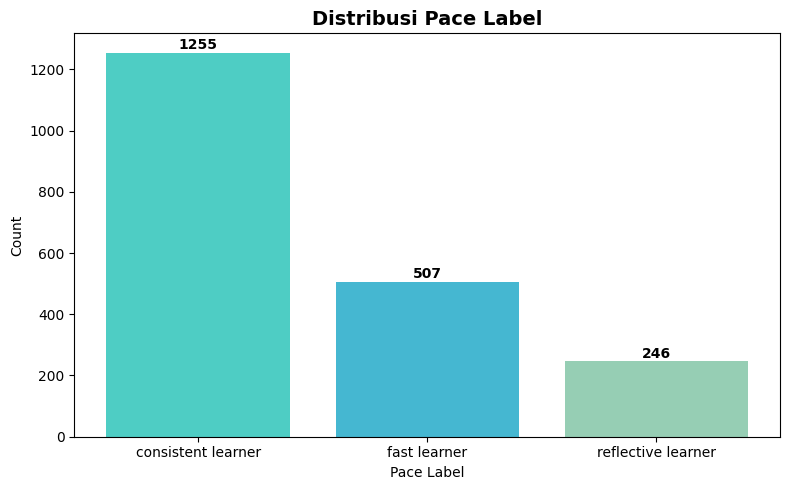

In [6]:
# Visualize distribution
plt.figure(figsize=(8, 5))
colors = ['#4ECDC4', '#45B7D1', '#96CEB4']
pace_counts = df['pace_label'].value_counts()

plt.bar(pace_counts.index, pace_counts.values, color=colors)
plt.title('Distribusi Pace Label', fontsize=14, fontweight='bold')
plt.xlabel('Pace Label')
plt.ylabel('Count')

for i, v in enumerate(pace_counts.values):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Prepare Features for Classification

In [7]:
# Define features
FEATURE_COLUMNS = [
    'completion_speed',
    'study_consistency_std',
    'avg_study_hour',
    'completed_modules',
    'total_modules_viewed'
]

# Prepare X and y
X = df[FEATURE_COLUMNS].copy()
y = df['pace_label'].copy()

# Handle missing values
X = X.fillna(X.median())

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
X.describe()

Features shape: (2008, 5)
Target shape: (2008,)


,completion_speed,study_consistency_std,avg_study_hour,completed_modules,total_modules_viewed
count,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000
mean,1.076897,63.583960,13.815199,39.993526,50.631972
std,1.932933,102.130422,3.901394,44.735601,46.315188
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.533333,0.000000,11.474080,2.000000,7.000000
50%,0.560000,5.857738,13.919643,24.500000,42.000000
75%,0.590217,97.251981,16.387234,66.000000,78.000000
max,10.000000,761.817709,23.000000,276.000000,286.000000


In [8]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {i}: {label}")

Label mapping:
  0: consistent learner
  1: fast learner
  2: reflective learner


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1606 samples
Test set: 402 samples


In [10]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!


## 4. Train Classification Model

In [11]:
# Train Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

# Predict
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Random Forest Results:")
print(f"  Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Random Forest Results:
  Training Accuracy: 1.0000 (100.00%)
  Test Accuracy: 1.0000 (100.00%)


In [12]:
# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Cross-Validation Scores: [1.         0.99376947 1.         1.         0.99688474]
Mean CV Score: 0.9981 (+/- 0.0050)


In [13]:
# Classification Report
print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

CLASSIFICATION REPORT
                    precision    recall  f1-score   support

consistent learner       1.00      1.00      1.00       251
      fast learner       1.00      1.00      1.00       102
reflective learner       1.00      1.00      1.00        49

          accuracy                           1.00       402
         macro avg       1.00      1.00      1.00       402
      weighted avg       1.00      1.00      1.00       402



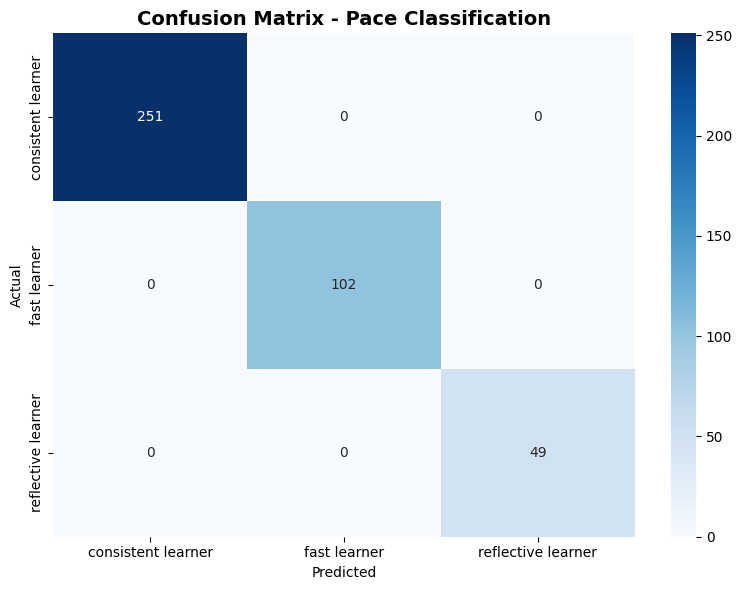

In [14]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Pace Classification', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

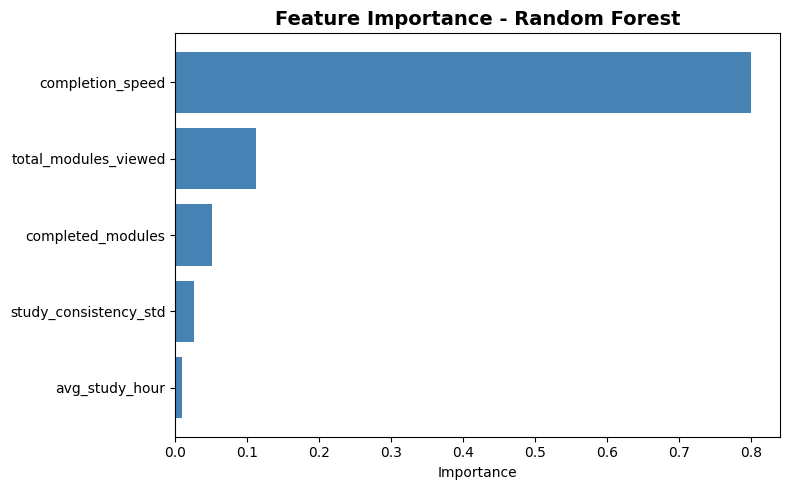


Feature Importance:
                 feature  importance
0       completion_speed    0.800427
4   total_modules_viewed    0.112338
3      completed_modules    0.051110
1  study_consistency_std    0.026391
2         avg_study_hour    0.009734


In [15]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLUMNS,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

## 5. Test with Specific Cases

In [16]:
# Test cases
test_cases = [
    {
        "name": "Fast Learner (speed=0.3)",
        "data": [0.3, 50.0, 14.0, 50, 60],
        "expected": "fast learner"
    },
    {
        "name": "Consistent Learner (speed=0.8)",
        "data": [0.8, 100.0, 13.0, 30, 50],
        "expected": "consistent learner"
    },
    {
        "name": "Reflective Learner (speed=2.5)",
        "data": [2.5, 150.0, 15.0, 20, 40],
        "expected": "reflective learner"
    }
]

print("="*60)
print("TEST CASES - Classification Model")
print("="*60)

correct = 0
total = len(test_cases)

for test in test_cases:
    X_test_case = pd.DataFrame([test['data']], columns=FEATURE_COLUMNS)
    X_test_scaled_case = scaler.transform(X_test_case)
    
    pred_encoded = model.predict(X_test_scaled_case)[0]
    pred_proba = model.predict_proba(X_test_scaled_case)[0]
    predicted = label_encoder.inverse_transform([pred_encoded])[0]
    confidence = pred_proba[pred_encoded]
    
    is_correct = predicted == test['expected']
    if is_correct:
        correct += 1
    
    status = "OK" if is_correct else "WRONG"
    
    print(f"\n{test['name']}:")
    print(f"  Expected: {test['expected']}")
    print(f"  Predicted: {predicted}")
    print(f"  Confidence: {confidence:.2%}")
    print(f"  Status: [{status}]")

print("\n" + "="*60)
print(f"RESULT: {correct}/{total} correct ({correct/total*100:.1f}%)")
print("="*60)

TEST CASES - Classification Model

Fast Learner (speed=0.3):
  Expected: fast learner
  Predicted: fast learner
  Confidence: 97.29%
  Status: [OK]

Consistent Learner (speed=0.8):
  Expected: consistent learner
  Predicted: consistent learner
  Confidence: 98.49%
  Status: [OK]

Reflective Learner (speed=2.5):
  Expected: reflective learner
  Predicted: reflective learner
  Confidence: 88.83%
  Status: [OK]

RESULT: 3/3 correct (100.0%)


## 6. Save Model for Production

In [17]:
# Create pace mapping
pace_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print("Pace Mapping:")
for k, v in pace_mapping.items():
    print(f"  {k}: {v}")

Pace Mapping:
  0: consistent learner
  1: fast learner
  2: reflective learner


In [18]:
# Save model as dictionary
model_package = {
    'model': model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'pace_mapping': pace_mapping,
    'feature_columns': FEATURE_COLUMNS,
    'model_type': 'classification',
    'model_metadata': {
        'algorithm': 'RandomForestClassifier',
        'n_estimators': 100,
        'training_accuracy': train_acc,
        'test_accuracy': test_acc,
        'cv_score_mean': cv_scores.mean(),
        'cv_score_std': cv_scores.std(),
        'n_classes': len(pace_mapping),
        'training_samples': len(X_train)
    }
}

# Save model
model_path = '../models/pace_classifier.pkl'
joblib.dump(model_package, model_path)
print(f"Model saved to: {model_path}")

# Verify
loaded = joblib.load(model_path)
print(f"\nVerification - Keys: {list(loaded.keys())}")
print(f"Model type: {loaded['model_type']}")
print(f"Metadata: {loaded['model_metadata']}")

Model saved to: ../models/pace_classifier.pkl

Verification - Keys: ['model', 'scaler', 'label_encoder', 'pace_mapping', 'feature_columns', 'model_type', 'model_metadata']
Model type: classification
Metadata: {'algorithm': 'RandomForestClassifier', 'n_estimators': 100, 'training_accuracy': 1.0, 'test_accuracy': 1.0, 'cv_score_mean': np.float64(0.9981308411214954), 'cv_score_std': np.float64(0.002492211838006231), 'n_classes': 3, 'training_samples': 1606}


## 7. Summary

In [19]:
print("="*60)
print("SUMMARY - PACE CLASSIFICATION MODEL")
print("="*60)

print(f"""
Model Type: Random Forest Classifier
Training Samples: {len(X_train)}
Test Samples: {len(X_test)}

Performance:
  - Training Accuracy: {train_acc:.2%}
  - Test Accuracy: {test_acc:.2%}
  - Cross-Validation: {cv_scores.mean():.2%} (+/- {cv_scores.std()*2:.2%})

Features Used:
  {FEATURE_COLUMNS}

Classes (3 Pace Labels):
  {list(label_encoder.classes_)}

Model Saved: {model_path}
""")

print("="*60)
print("Model siap digunakan di API!")
print("="*60)

SUMMARY - PACE CLASSIFICATION MODEL

Model Type: Random Forest Classifier
Training Samples: 1606
Test Samples: 402

Performance:
  - Training Accuracy: 100.00%
  - Test Accuracy: 100.00%
  - Cross-Validation: 99.81% (+/- 0.50%)

Features Used:
  ['completion_speed', 'study_consistency_std', 'avg_study_hour', 'completed_modules', 'total_modules_viewed']

Classes (3 Pace Labels):
  ['consistent learner', 'fast learner', 'reflective learner']

Model Saved: ../models/pace_classifier.pkl

Model siap digunakan di API!
